In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [10]:
import examples as eg
import dionysus

The circular coordinates pipeline for examining different smoothness cost-functions:

    Step 1. Getting the point cloud
    Step 2. Computing the Vietoris-Rips filtration and its cohomology
    Step 3. Selecting the Cocycle
    Step 4. First smoothing using Least Squares (Optional)
    Step 5. Second smoothing using a new cost function

## Step 1 - Getting the point cloud

In [8]:
annulus = eg.annulus_variable_d_example()

## Step 2 - Computing VR and Cohomology

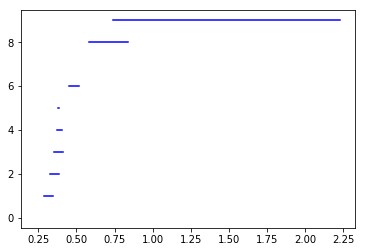

In [11]:
prime = 23

vr = dionysus.fill_rips(annulus, 2, 4.)
cp = dionysus.cohomology_persistence(vr, prime, True)
dgms = dionysus.init_diagrams(cp, vr)
dionysus.plot.plot_bars(dgms[1], show=True)

## Step 3 - Selecting the cocycle

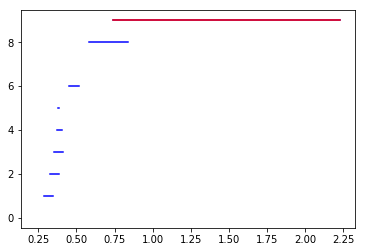

In [20]:
bars = [bar for bar in dgms[1] if bar.death-bar.birth > 1.]

dionysus.plot.plot_bars(dgms[1], show=False)
plt.plot([[bar.birth,bar.death] for bar in dgms[1] if bar.death-bar.birth > 1.][0],[[x,x] for x,bar in enumerate(dgms[1]) if bar.death-bar.birth > 1.][0],'r')